In [19]:
#!sudo pip install xgboost

In [20]:
#!sudo pip install shap

In [21]:
#!sudo pip install lightgbm

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mode
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import shap

In [23]:
INPUT_DIR = '/home/jupyter/data-science-bowl/'

In [24]:
# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

In [ ]:
%%time
keep_cols = ['event_id', 'game_session', 'installation_id', 'event_count',
             'event_code','title' ,'game_time', 'type', 'world','timestamp']
train=pd.read_csv(os.path.join(INPUT_DIR,'train.csv'),usecols=keep_cols)
train_labels=pd.read_csv(os.path.join(INPUT_DIR,'train_labels.csv'), usecols=['installation_id','game_session','accuracy_group'])
test=pd.read_csv(os.path.join(INPUT_DIR,'test.csv'),usecols=keep_cols)
submission=pd.read_csv(os.path.join(INPUT_DIR,'sample_submission.csv'))

In [14]:
train.shape,train_labels.shape

((11341042, 10), (17690, 3))

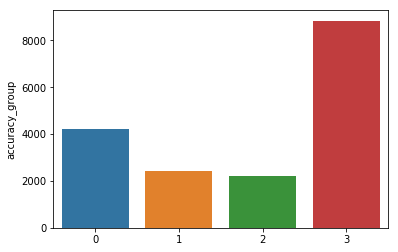

In [15]:
x=train_labels['accuracy_group'].value_counts()
sns.barplot(x.index,x)

In [16]:
not_req=(set(train.installation_id.unique()) - set(train_labels.installation_id.unique()))

In [17]:
train_new=~train['installation_id'].isin(not_req)
train.where(train_new,inplace=True)
train.dropna(inplace=True)

In [18]:
train['event_code']=train.event_code.astype(int)

In [27]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    return df

In [28]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'installation_id',
       'event_count', 'event_code', 'game_time', 'title', 'type', 'world'],
      dtype='object')

In [29]:
time_features=['month','hour','year','dayofweek','weekofyear']
def prepare_data(df):
    df=extract_time_features(df)
    
    df=df.drop('timestamp',axis=1)
    #df['timestamp']=pd.to_datetime(df['timestamp'])
    #df['hour_of_day']=df['timestamp'].map(lambda x : int(x.hour))
    

    join_one=pd.get_dummies(df[['event_code','installation_id','game_session']],
                            columns=['event_code']).groupby(['installation_id','game_session'],
                                                            as_index=False,sort=False).agg(sum)

    agg={'event_count':sum,'game_time':['sum','mean'],'event_id':'count'}

    join_two=df.drop(time_features,axis=1).groupby(['installation_id','game_session']
                                                   ,as_index=False,sort=False).agg(agg)
    
    join_two.columns= [' '.join(col).strip() for col in join_two.columns.values]
    

    join_three=df[['installation_id','game_session','type','world','title']].groupby(
                ['installation_id','game_session'],as_index=False,sort=False).first()
    
    join_four=df[time_features+['installation_id','game_session']].groupby(['installation_id',
                'game_session'],as_index=False,sort=False).agg(mode)[time_features].applymap(lambda x: x.mode[0])
    
    join_one=join_one.join(join_four)
    
    join_five=(join_one.join(join_two.drop(['installation_id','game_session'],axis=1))). \
                        join(join_three.drop(['installation_id','game_session'],axis=1))
    
    return join_five

In [35]:
month = list()
hour = list()
year = list()
dayofweek = list()
weekofyear = list()
for idx, row in train.iterrows():
    row['timestamp'] = pd.to_datetime(row['timestamp'])
    month.append(row['timestamp'].dt.month)
    hour.append(row['timestamp'].dt.hour)
    year.append(row['timestamp'].dt.year)
    dayofweek.append(row['timestamp'].dt.dayofweek)
    weekofyear.append(row['timestamp'].dt.weekofyear)

MemoryError: Unable to allocate 590. MiB for an array with shape (10, 7734558) and data type object

In [36]:
idx

NameError: name 'idx' is not defined